In [3]:
# import libraries
import numpy as np

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
from scipy.integrate import quad



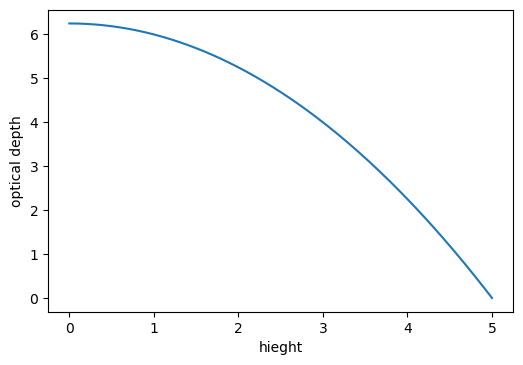

0.1999983230060726


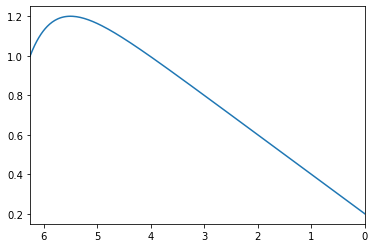

In [4]:
grid_x = 200
z_max = 5 ; az = 0.5
x = np.linspace(0,z_max,grid_x)
z = x
#optical depth
x = az/2*(z_max**2 - (x**2))
plt.figure(1,dpi=100)
plt.xlabel("hieght") ; plt.ylabel("optical depth") 
plt.plot(z,x)
plt.show()

#print("Optical_Depth",x)

a = .1
b = .2
I=1
I_final = []

mu = .5

def integrand(x, a, b,t):
    return (a+(b*x))*np.exp(-(x - t)*(1/mu))*(1/mu)

for i in range(0,len(x)):
    temp1 = I*np.exp(-(np.amax(x) - x[i])*(1/mu))
    temp = quad(integrand, x[i] , np.amax(x), args=(a,b,x[i]))
    I_final.append(temp[0]+temp1) 

plt.plot((x),(I_final))
plt.xlim(np.amax(x),np.amin(x))
print(I_final[-1])

0
40
80
120
160


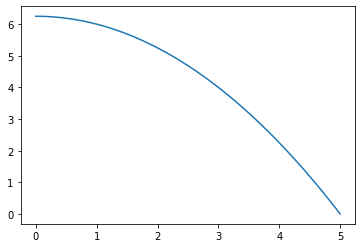

In [42]:

def Srce(tau):
    return (a+b*tau)

Srce = np.vectorize(Srce)

x = np.linspace(0,z_max,grid_x)
z = x
#optical depth
x = az/2*(z_max**2 - (x**2))
plt.plot(z,x)
#First some function values at some point 

y_p = []
fy_p = []
for i in range(0,grid_x,20):
    y_p.append(x[i])
    fy_p.append(I_final[i])
#    print(i)
#y_p  = np.array([x[0], x[199]])
#fy_p = np.array([I_final[0],I_final[199]])

#y_p.append(x[-1])
#fy_p.append(I_final[-1])

y_p = np.array(y_p)
fy_p = np.array(fy_p)


#Second some values for the L operator at some points
y_d = []
for i in range(0,grid_x,40):
    y_d.append(x[i])
    print(i)
   
y_d = np.array(y_d)

#y_d  = np.array([x[50] , x[99] , x[190]])
fy_d = np.array(Srce(y_d))

#plt.plot(y_p,fy_p)

In [43]:
alpha = 0.1
h = 0.5

def kernel(x, y, h):
    return alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)

def Lx_kernel(x, y, h):
    return (h**2 - (x-y)) / h**2 * kernel(x, y, h)

def Ly_kernel(x, y, h):
    return (h**2 + (x-y)) / h**2 * kernel(x, y, h)

def L2_kernel(x, y, h):
    return (h**4 + h**2 - (x-y)**2) / h**4 * kernel(x, y, h)


def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_kernel(x, y, h).T

def Ly_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_kernel(x, y, h).T

def L2_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_kernel(x, y, h).T


In [44]:
def GP_fit(h):
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])

    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                             [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])


    fy = np.block([fy_p, fy_d])
    
    P = np.diag(np.diag(sigma_11))
    temp = np.matmul(sigma_11,np.linalg.inv(P))
    temp = np.linalg.inv(temp)
    temp = np.matmul(temp,fy)
    temp = np.matmul(np.linalg.inv(P),temp)
    
    #M =  np.matmul(sigma_11,np.linalg.inv(np.diag(sigma_11)))
    #print(np.linalg.det(M))
    #M = np.matmul(np.linalg.inv(M),fy)
    #M = np.matmul(np.linalg.inv(np.diag(sigma_11)) , M)
    
    mean = np.matmul(sigma_10, temp)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)
    print(np.linalg.det(sigma_11))
    fs = np.random.multivariate_normal(mean, cov, 25).T
    
    plt.figure(1,dpi = 100)
    plt.plot(x, mean, linewidth=0.90)
    plt.plot(x, I_final, 'k')
    plt.xlim(np.amax(x),np.amin(x))
    plt.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    plt.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    plt.plot(x, fs, c='gray', linewidth=0.2)
    plt.show()
    
    plt.imshow(cov)
    plt.show()
    
    plt.scatter(x, np.abs(I-mean) )
    plt.show()
    

interact(GP_fit,h=(0.01,.5,0.0001))

interactive(children=(FloatSlider(value=0.255, description='h', max=0.5, min=0.01, step=0.0001), Output()), _d…

<function __main__.GP_fit(h)>

In [23]:
print(np.diag(sigma_11))

NameError: name 'sigma_11' is not defined

In [30]:

sigma_00 = corr(x, x, h)

sigma_10 = np.block([   corr(x, y_p, h),
                     Ly_corr(x, y_d, h) ])

sigma_01 = np.block([   corr(y_p, x, h).T,
                     Lx_corr(y_d, x, h).T ]).T

sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])


fy = np.block([fy_p, fy_d])


#M =  np.matmul(sigma_11,np.linalg.inv(np.diag(sigma_11)))
#print(np.linalg.det(M))
#M = np.matmul(np.linalg.inv(M),fy)
#M = np.matmul(np.linalg.inv(np.diag(sigma_11)) , M)

#mean = np.matmul(sigma_10, M)
#cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)
print(np.diag(sigma_11))
#fs = np.random.multivariate_normal(mean, cov, 25).T

#plt.figure(1,dpi = 100)
#plt.plot(x, mean, linewidth=0.90)
#plt.plot(x, I_final, 'k')
#plt.xlim(np.amax(x),np.amin(x))
#plt.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
#plt.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
#plt.plot(x, fs, c='gray', linewidth=0.2)
#plt.show()

#plt.imshow(cov)
#plt.show()

#plt.scatter(x, np.abs(I-mean) )
#plt.show()



[0.01 0.01 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


In [33]:
print(np.linalg.det(sigma_11))
P = np.diag(np.diag(sigma_11))
temp = np.matmul(sigma_11,np.linalg.inv(P))
print(np.linalg.det(temp))

5.201338480444304e-71
5.454017381946584e-41
